In [83]:
from collections import Counter
from dataset_formatted import df
from collections import defaultdict
from urllib.parse import urlparse
import matplotlib.pyplot as plt
import pandas as pd
import tldextract
import numpy as np

### <span style="color:lightgreen">Basic Statistics & Summary of the Data:</span> 



In [84]:
df.info()

# A couple of things to note:
# 1. Check the fields that don't have 600 non-null values and decide how we want to handle these.
# 2. Do we need to remove any other columns?

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 10 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   Question                         600 non-null    object        
 1   Question Category                600 non-null    object        
 2   LLM                              600 non-null    object        
 3   Model Version                    600 non-null    object        
 4   Explicit Attribution             585 non-null    object        
 5   Date                             600 non-null    datetime64[ns]
 6   Attributed Sources               366 non-null    object        
 7   Number of Sources                585 non-null    float64       
 8   Are All Source Links Functional  368 non-null    object        
 9   Multi-modal Response             578 non-null    object        
dtypes: datetime64[ns](1), float64(1), object(8)
memory usage: 47.0

### <span style="color:lightgreen">EDA 1:</span>  <span style="color:lightgreen">Total Number of Sources by Model & Average Number of Sources by Model Per Question<span>



In [85]:
total_number_of_sources_by_model = df.groupby('LLM')['Number of Sources'].sum()
avg_number_of_sources_by_model_per_question= df.groupby('LLM')['Number of Sources'].sum() / 100
print(f'\nTotal Number of Sources by Model \n\n{total_number_of_sources_by_model}', '\n\n')
print(f'Average Number of Sources Per Question by Model \n\n{avg_number_of_sources_by_model_per_question}')



Total Number of Sources by Model 

LLM
chatGPT       944.0
copilot        55.0
gemini        315.0
grok            0.0
llama          30.0
perplexity    648.0
Name: Number of Sources, dtype: float64 


Average Number of Sources Per Question by Model 

LLM
chatGPT       9.44
copilot       0.55
gemini        3.15
grok          0.00
llama         0.30
perplexity    6.48
Name: Number of Sources, dtype: float64


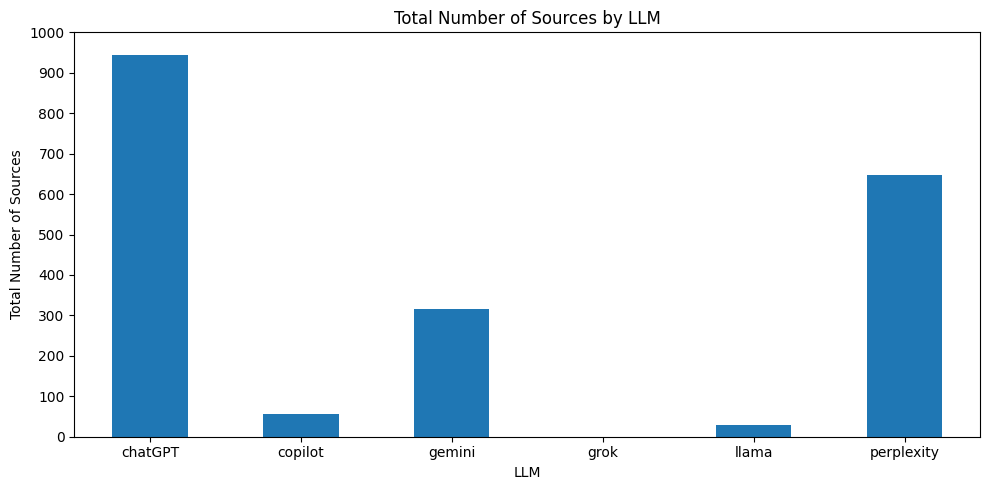

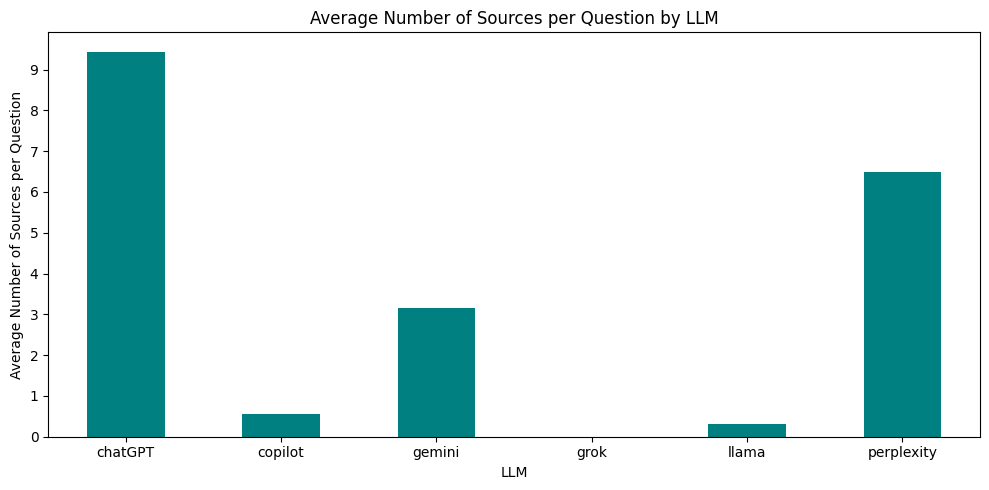

In [86]:
fig, ax1 = plt.subplots(figsize=(10, 5))
total_number_of_sources_by_model.plot(kind='bar', ax=ax1, title='Total Number of Sources by LLM')
ax1.set_ylabel('Total Number of Sources')
ax1.set_xlabel('LLM')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)
ax1.set_yticks(range(0, int(total_number_of_sources_by_model.max()) + 100, 100))
plt.tight_layout()
plt.show()

fig, ax2 = plt.subplots(figsize=(10, 5))
avg_number_of_sources_by_model_per_question.plot(kind='bar', ax=ax2, color='teal', title='Average Number of Sources per Question by LLM')
ax2.set_ylabel('Average Number of Sources per Question')
ax2.set_xlabel('LLM')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)
ax2.set_yticks(range(0, int(avg_number_of_sources_by_model_per_question.max()) + 1, 1))
plt.tight_layout()
plt.show()


### <span style="color:lightgreen">EDA 2:</span>  <span style="color:lightgreen">Exploration of Source Characteristics<span>

In [87]:
df.groupby('Question Category')['Question'].count()

Question Category
Economics & Commerce     42
Entertainment           150
Food & Cooking           18
General Knowledge        18
Geography                30
History                 108
Literature               30
Philosophy               18
Politics                 30
Science & Technology    102
Sports                   54
Name: Question, dtype: int64

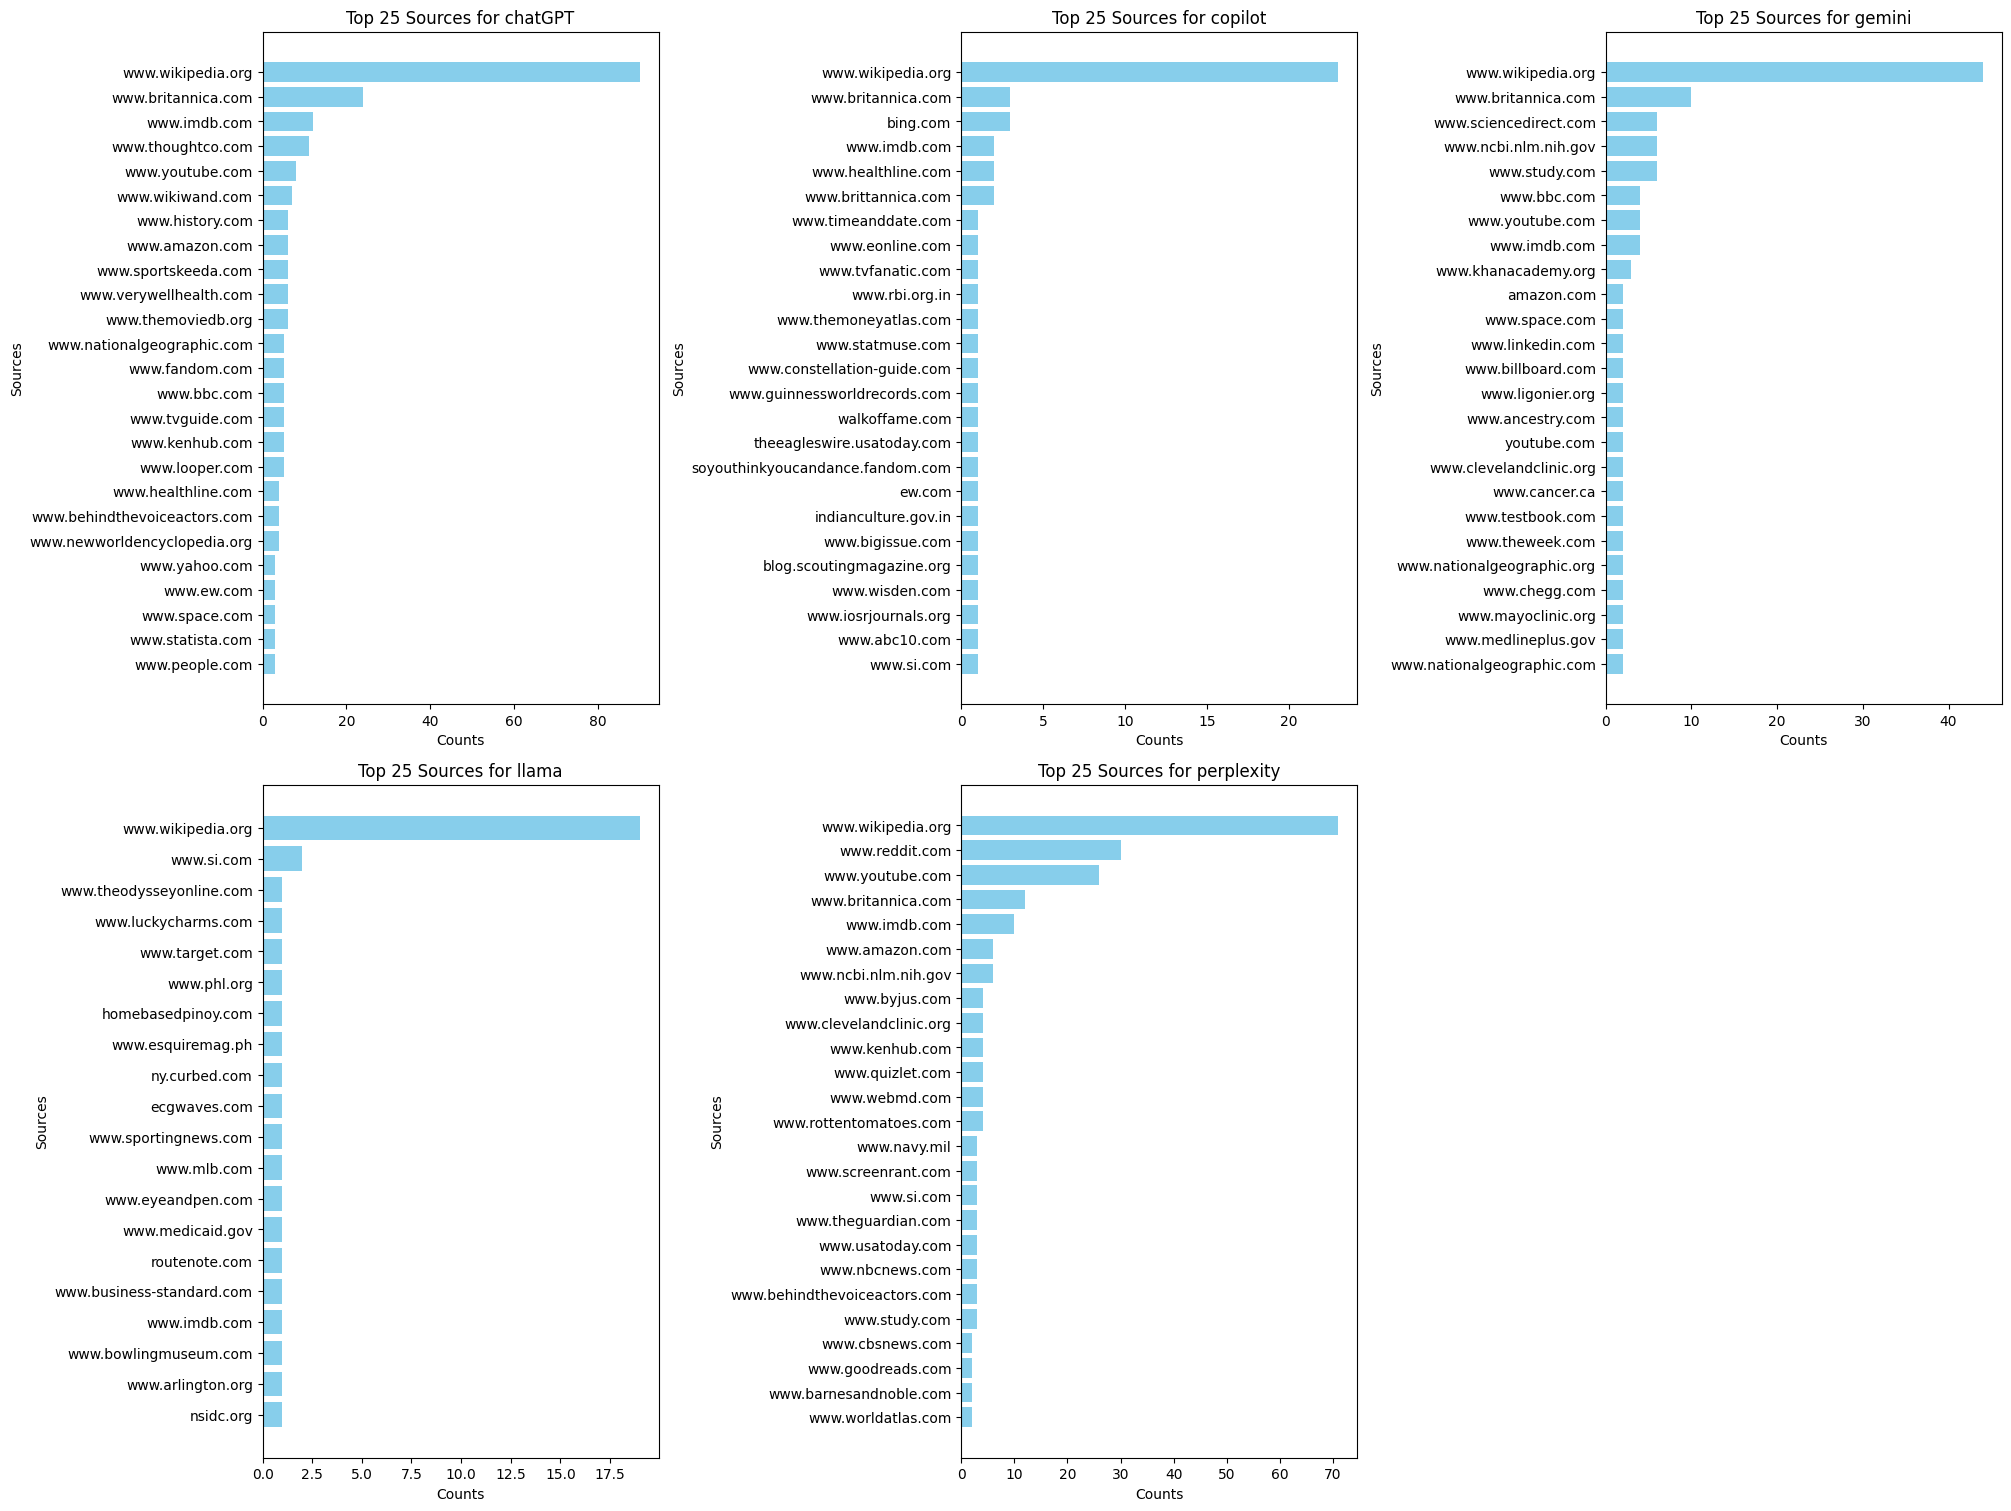

In [88]:
df_links = df.__deepcopy__()

df_links_grouped = df_links.groupby('LLM')['Attributed Sources'].apply(lambda x: ','.join(x.dropna()).split(','))

llm_link_counts = {}

for llm, links in df_links_grouped.items():
    flattened_link_list = [link.strip() for link in links]
    link_counts = Counter(flattened_link_list)
    llm_link_counts[llm] = link_counts

fig, axes = plt.subplots(2, 3, figsize=(20, 15), constrained_layout=True)
axes = axes.flatten()

plot_count = 0

for llm, counts in llm_link_counts.items():
    if llm == 'grok':
        continue
    top_25_links = counts.most_common(25)
    links, counts = zip(*top_25_links)
    
    ax = axes[plot_count]
    ax.barh(links, counts, color='skyblue')
    ax.set_xlabel('Counts')
    ax.set_ylabel('Sources')
    ax.set_title(f'Top 25 Sources for {llm}')
    ax.invert_yaxis()  
    plot_count += 1

for i in range(plot_count, len(axes)):
    fig.delaxes(axes[i])

plt.show()



### <span style="color:lightgreen">EDA 3:</span>  <span style="color:lightgreen">Exploration of Top Level Domains (TLDs) & Creation of Additional Feature Columns to Dataset<span>

In [89]:
df_links_formatting_tld = df.__deepcopy__()

Top 10 TLDs Across All Models: 

[('com', 1189), ('org', 510), ('gov', 107), ('edu', 39), ('in', 25), ('net', 23), ('com ', 19), ('co', 17), ('uk', 14), ('au', 8)]


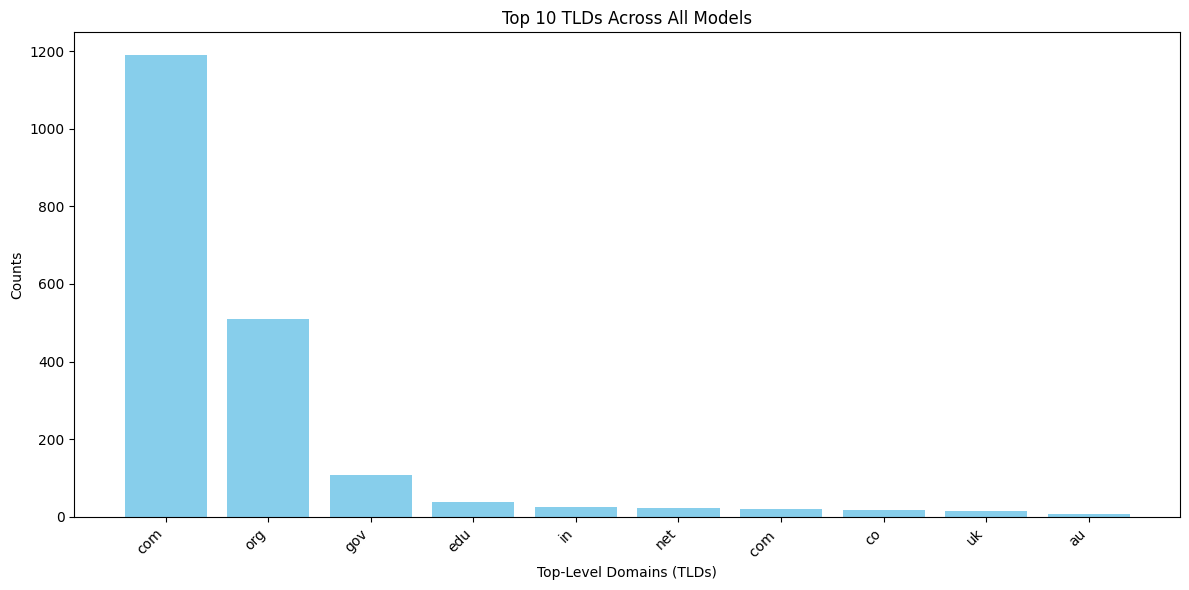

In [90]:
tld_counts = {}

for key, links in df_links_grouped.items():
    for link in links:
        if not link: 
            continue
        if not link.startswith(('https://')):
            link = 'https://' + link  
        domain = urlparse(link).netloc
        if not domain:
            continue
        tld = domain.split('.')[-1]
        if tld in tld_counts:
            tld_counts[tld] += 1
        else:
            tld_counts[tld] = 1

top_10_tlds = sorted(tld_counts.items(), key=lambda item: item[1], reverse=True)[:10]
print(f'Top 10 TLDs Across All Models: \n\n{top_10_tlds}')
tlds, counts = zip(*top_10_tlds)

plt.figure(figsize=(12, 6))
plt.bar(tlds, counts, color='skyblue')
plt.xlabel('Top-Level Domains (TLDs)')
plt.ylabel('Counts')
plt.title('Top 10 TLDs Across All Models')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [91]:
new_columns = ['.com count', '.org count', '.gov count', '.edu count', 'other count']
positions = [8, 9, 10, 11, 12]

for col, pos in zip(new_columns, positions):
    df_links_formatting_tld.insert(pos, col, 0)


def count_tlds(row):
    tld_counts = {
        '.com': 0,
        '.org': 0,
        '.gov': 0,
        '.edu': 0,
        'other': 0
    }
    links = row.split(', ')
    for link in links:
        link = link.strip()
        if not link.startswith(('http://', 'https://')):
            link = 'http://' + link
        tld_info = tldextract.extract(link)
        tld = '.' + tld_info.suffix
        if tld in tld_counts:
            tld_counts[tld] += 1
        # else:
        #     tld_counts['other'] += 1
    return pd.Series(tld_counts)

df_links_formatting_tld['Attributed Sources'] = df_links_formatting_tld['Attributed Sources'].fillna('')
df_links_formatting_tld[['.com count', '.org count', '.gov count', '.edu count', 'other count']] = df_links_formatting_tld['Attributed Sources'].apply(count_tlds)

df_links_formatting_tld.head()

# df_links_formatting_tld.to_csv('df_links_formatting_tld.csv', index=False)

,Question,Question Category,LLM,Model Version,Explicit Attribution,Date,Attributed Sources,Number of Sources,.com count,.org count,.gov count,.edu count,other count,Are All Source Links Functional,Multi-modal Response
0,"""where does the saying keeping up with the jon...",General Knowledge,gemini,gemini_1.5_pro,explicit_attribution,2024-11-02,"www.commonlit.org, www.history.howstuffworks.com",2.0,1,1,0,0,0,all_links_functional,text_only
1,"""when did day light savings start in the us""",History,gemini,gemini_1.5_pro,explicit_attribution,2024-11-02,www.wikipedia.org,1.0,0,1,0,0,0,all_links_functional,text_only
2,"""what is the doll in the garden about""",Entertainment,gemini,gemini_1.5_pro,explicit_attribution,2024-11-02,"www.goodreads.com, amazon.com, www.publishersw...",3.0,3,0,0,0,0,all_links_functional,text_only
3,"""where is a unitary system of government found""",Politics,gemini,gemini_1.5_pro,explicit_attribution,2024-11-02,"www.britannica.com, www.guides.skylinecollege....",3.0,1,1,0,1,0,all_links_functional,text_only
4,"""who dies in season 2 of the originals""",Entertainment,gemini,gemini_1.5_pro,explicit_attribution,2024-11-02,www.wikipedia.org,1.0,0,1,0,0,0,all_links_functional,text_only


### <span style="color:lightgreen">Development of Trust Score:</span> 

In [ ]:
df_trust_score = df_links_formatting_tld.__deepcopy__()

df_trust_score['Multi-modal Response'] = df_trust_score['Multi-modal Response'].fillna('text_only')

df_trust_score.insert(15, 'Trust Score', 0)

for index, r in df_trust_score.iterrows():
    trust_score = 0
    if r['Number of Sources'] > 0:
        trust_score += 5
    if r['.com count'] > 0:
        trust_score += (r['.com count'] * 1)
    if r['.org count'] > 0:
        trust_score += (r['.org count'] * 1)
    if r['.gov count'] > 0:
        trust_score += (r['.gov count'] * 1)
    if r['.edu count'] > 0:
        trust_score += (r['.edu count'] * 1)
    if r['Are All Source Links Functional'] == 'all_links_functional':
        trust_score += 2
    elif r['Are All Source Links Functional'] == 'some_links_funcitonal':
        trust_score += 1
    if r['Attributed Sources'] != '':
        unique_sources = set(r['Attributed Sources'].split(', '))
        trust_score += len(unique_sources)
    if r['Multi-modal Response'] == 'multi-modal':
        trust_score += 1

    df_trust_score.at[index, 'Trust Score'] = trust_score

df_trust_score.head()


,Question,Question Category,LLM,Model Version,Explicit Attribution,Date,Attributed Sources,Number of Sources,.com count,.org count,.gov count,.edu count,other count,Are All Source Links Functional,Multi-modal Response,Trust Score
0,"""where does the saying keeping up with the jon...",General Knowledge,gemini,gemini_1.5_pro,explicit_attribution,2024-11-02,"www.commonlit.org, www.history.howstuffworks.com",2.0,1,1,0,0,0,all_links_functional,text_only,11
1,"""when did day light savings start in the us""",History,gemini,gemini_1.5_pro,explicit_attribution,2024-11-02,www.wikipedia.org,1.0,0,1,0,0,0,all_links_functional,text_only,9
2,"""what is the doll in the garden about""",Entertainment,gemini,gemini_1.5_pro,explicit_attribution,2024-11-02,"www.goodreads.com, amazon.com, www.publishersw...",3.0,3,0,0,0,0,all_links_functional,text_only,13
3,"""where is a unitary system of government found""",Politics,gemini,gemini_1.5_pro,explicit_attribution,2024-11-02,"www.britannica.com, www.guides.skylinecollege....",3.0,1,1,0,1,0,all_links_functional,text_only,13
4,"""who dies in season 2 of the originals""",Entertainment,gemini,gemini_1.5_pro,explicit_attribution,2024-11-02,www.wikipedia.org,1.0,0,1,0,0,0,all_links_functional,text_only,9


In [110]:
mean_by_model = df_trust_score.groupby('LLM')['Trust Score'].mean()
print(f'Mean Trust Score by Model: \n\n{mean_by_model}')

Mean Trust Score by Model: 

LLM
chatGPT       23.46
copilot        5.43
gemini        11.88
grok           0.00
llama          2.87
perplexity    20.23
Name: Trust Score, dtype: float64


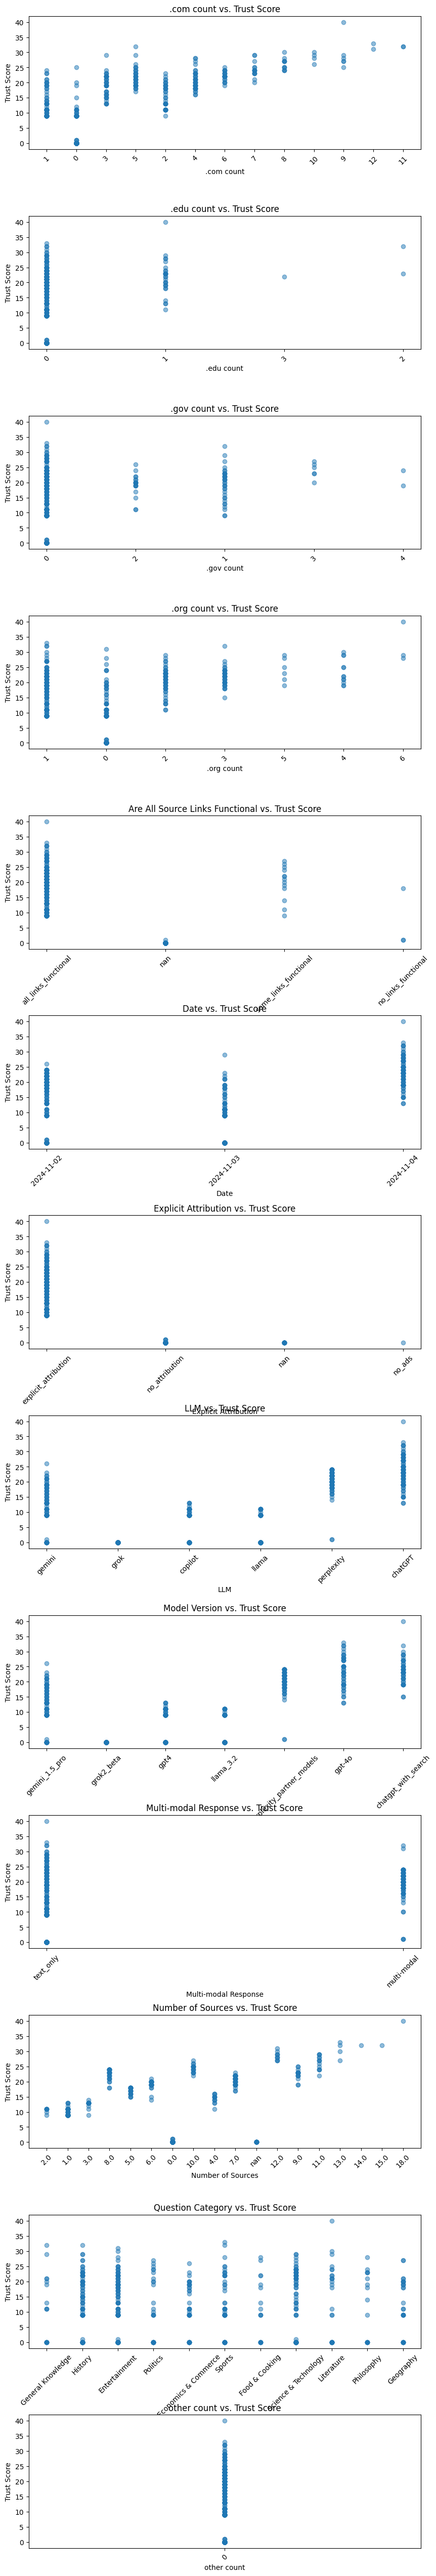

In [ ]:
feature_columns = df_trust_score.columns.difference(['Trust Score', 'Attributed Sources', 'Question'])

fig, axes = plt.subplots(len(feature_columns), 1, figsize=(10, len(feature_columns) * 5))
axes = axes.flatten()

for ax, feature in zip(axes, feature_columns):
    ax.scatter(df_trust_score[feature].astype(str), df_trust_score['Trust Score'], alpha=0.5)
    ax.set_xlabel(feature)
    ax.set_ylabel('Trust Score')
    ax.set_title(f'{feature} vs. Trust Score')
    ax.tick_params(axis='x', rotation=0)

plt.subplots_adjust(hspace=0.5)
plt.show()

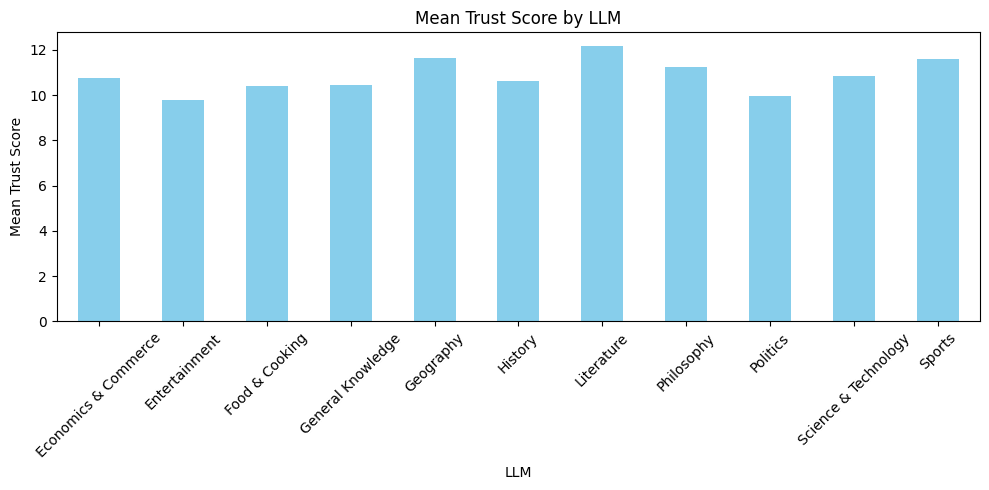

In [107]:
plt.figure(figsize=(10, 5))
df_trust_score.groupby('Question Category')['Trust Score'].mean().plot(kind='bar', color='skyblue')
plt.xlabel('LLM')
plt.ylabel('Mean Trust Score')
plt.title('Mean Trust Score by LLM')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()